# Pronóstico de fallas para mantenimiento predictivo usando metodologías de aprendizaje profundo supervisado

### Francisco Araya López - Departamento de Eléctronica - UTFSM

### Turbofan Engine Degradation Simulation Dataset

### Octubre 2020

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import random
import time


%matplotlib inline

In [2]:
# PARAMETROS

#tamaño time windows de cada dataset
W_H_FD001 = 10 #MAX 31
W_H_FD002 = 10 #MAX 21
W_H_FD003 = 10 #MAX 39
W_H_FD004 = 10 #MAX 19
#Numero de features 
W_W_FDXXX = 14
#Semilla para generador numeros pseudoaleatorios // seed random number generator
SEED = 7
#Porcentaje datos entrenamiento respecto al total // percent training set
T_V_SPLIT = 0.9
# Optimizer

OPTIM = "Adam"

#HIPERPARAMETROS
BATCH_SIZE_T = 1024 #batch size all
EPOCHS_MAX = 250 #EPOCHS MAX




In [3]:
# window_h is the height of the time windows in the dataset
# window_w is the width of the time windows in the dataset
# seed is the seed of the random number generator used in shuffle function, for shuffle pairs (X,Y) before
# feed CNN in training process.
# t_v_split is the percentage of data used as training and the rest is used for validation data.

def build_train_and_test_set(path_train,path_test,path_rul,window_h,window_w,seed,t_v_split):
  
  #create (X,Y,Z) array with feature maps and rul vector for training and validation // Creacion matriz multidimensional de feature maps y vector de rul para entrenamiento (y validacion)

  df = pd.read_csv(path_train, sep = ' ', header = None)
  df = df.drop(columns=[26, 27])
  df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Add RUL variable // Agregada variable RUL a df y normalización de columnas (salvo RUL)
  
  RUL_temp=np.zeros(0)
  for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
  df['RUL'] = RUL_temp
  df['RUL'] = df['RUL'].astype(int)
  scaler = MinMaxScaler(feature_range=(-1,1))
  df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

  #Feature maps creation // Creación de features maps
  features_maps=np.empty((window_h,window_w,1))
  df_ys = np.zeros((1,1))
  
  #se obtienen los dataset de engines independientes en df_temp
  for i in range(1,df['n_engine'].max()+1):
    df_temp1 = df[df['n_engine'] == i]
    df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_features = df_temp2.drop(['RUL'],axis = 1)
    df_y = df_temp2['RUL'].to_numpy()
    df_ys = np.append(df_ys,df_y[(window_h - 1):])
    for j in range(len(df_y)-(window_h - 1)):
      feature_map = df_features[j:j+(window_h)][:]
      features_maps = np.dstack((features_maps, feature_map))
  features_maps=np.delete(features_maps, 0, 2)
  df_ys = np.delete(df_ys, 0, 0)
  
  # change of dimension order // cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps = np.moveaxis(features_maps, 2, 0)

  # Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
  df_ys = np.expand_dims(df_ys,axis=1)
  features_maps= np.expand_dims(features_maps,3)

  #random para pares (X,Y) del conjunto de entrenamiento
  features_maps, df_ys = shuffle(features_maps, df_ys, random_state=seed)

  #valores de RUL mayores a 125 se seteean en 120 (modificacion Target RUL = 120)
  for i in range(len(df_ys)):
    if df_ys[i] >= 120:
      df_ys[i] = 120

  ys_train = df_ys[:int(len(df_ys)*(t_v_split))]
  ys_valid = df_ys[int(len(df_ys)*(t_v_split)):]

  features_maps_train = features_maps[:int(len(df_ys)*(t_v_split))]
  features_maps_valid = features_maps[int(len(df_ys)*(t_v_split)):]

  #CREACION DE FEATURES MAPS Y RULS PARA TESTEO

  df_t = pd.read_csv(path_test, sep = ' ', header = None)
  df_t = df_t.drop(columns=[26, 27])
  df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

  #se obtienen los dataset de engines independientes en df_temp
  features_maps_test=np.empty((window_h,window_w,1))
  for i in range(1,df_t['n_engine'].max()+1):
    df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_large = df_temp['sens_8'].count()
    feature_map = df_temp[df_large-(window_h):][:]
    features_maps_test = np.dstack((features_maps_test, feature_map))
  features_maps_test=np.delete(features_maps_test, 0, 2)
  
  # cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps_test = np.moveaxis(features_maps_test, 2, 0)
  features_maps_test = np.expand_dims(features_maps_test,3)

  ruls_test= []
  rul_file = open(path_rul, "r")
  for rul_line in rul_file:
    ruls_test.append(int(rul_line.rstrip(' \n')))

  ruls_test_final = np.array(ruls_test)
  features_maps_test_final = np.array(features_maps_test)
  idx   = np.argsort(ruls_test_final)

  ruls_test_final = np.array(ruls_test_final)[idx]
  features_maps_test_final = np.array(features_maps_test_final)[idx]

  for i in range(len(ruls_test_final)):
    if ruls_test_final[i] >= 120:
      ruls_test_final[i] = 120

  return ys_train, ys_valid, features_maps_train, features_maps_valid, ruls_test_final, features_maps_test_final


In [4]:
y_train1, y_valid1, f_maps_train1, f_maps_valid1, r_test_f1, f_maps_test_f1 = (build_train_and_test_set('train_FD001.txt','test_FD001.txt','RUL_FD001.txt',W_H_FD001,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [5]:
y_train2, y_valid2, f_maps_train2, f_maps_valid2, r_test_f2, f_maps_test_f2 = (build_train_and_test_set('train_FD002.txt','test_FD002.txt','RUL_FD002.txt',W_H_FD002,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [6]:
y_train3, y_valid3, f_maps_train3, f_maps_valid3, r_test_f3, f_maps_test_f3 = (build_train_and_test_set('train_FD003.txt','test_FD003.txt','RUL_FD003.txt',W_H_FD003,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [7]:
y_train4, y_valid4, f_maps_train4, f_maps_valid4, r_test_f4, f_maps_test_f4 = (build_train_and_test_set('train_FD004.txt','test_FD004.txt','RUL_FD004.txt',W_H_FD004,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [8]:
#Union de datasets

#FD001+FD003
f_maps_train13 = np.append(f_maps_train1,f_maps_train3,axis=0)
f_maps_valid13 = np.append(f_maps_valid1,f_maps_valid3,axis=0)
f_maps_13 = np.append(f_maps_train13,f_maps_valid13,axis=0)
print(f_maps_13.shape)
y_train13 = np.append(y_train1,y_train3,axis=0)
y_valid13 = np.append(y_valid1,y_valid3,axis=0)
y_13 = np.append(y_train13,y_valid13,axis=0)
print(y_13.shape)
f_maps_test_f1f3 = np.append(f_maps_test_f1,f_maps_test_f3,axis=0)
r_test_f1f3 = np.append(r_test_f1,r_test_f3)
print(f_maps_test_f1f3.shape)
print(r_test_f1f3.shape)

#FD002+FD004

f_maps_train24 = np.append(f_maps_train2,f_maps_train4,axis=0)
f_maps_valid24 = np.append(f_maps_valid2,f_maps_valid4,axis=0)
f_maps_24 = np.append(f_maps_train24,f_maps_valid24,axis=0)
print(f_maps_24.shape)
y_train24 = np.append(y_train2,y_train4,axis=0)
y_valid24 = np.append(y_valid2,y_valid4,axis=0)
y_24 = np.append(y_train24,y_valid24,axis=0)
print(y_24.shape)
f_maps_test_f2f4 = np.append(f_maps_test_f2,f_maps_test_f4,axis=0)
r_test_f2f4 = np.append(r_test_f2,r_test_f4)
print(f_maps_test_f2f4.shape)
print(r_test_f2f4.shape)

(43551, 10, 14, 1)
(43551, 1)
(200, 10, 14, 1)
(200,)
(110427, 10, 14, 1)
(110427, 1)
(507, 10, 14, 1)
(507,)


In [9]:
#Ordenamiento menor a mayor por RUL pares (X,Y) test set

idx   = np.argsort(r_test_f1f3)
r_test_f1f3 = np.array(r_test_f1f3)[idx]
f_maps_test_f1f3 = np.array(f_maps_test_f1f3)[idx]


idx2   = np.argsort(r_test_f2f4)
r_test_f2f4 = np.array(r_test_f2f4)[idx2]
f_maps_test_f2f4 = np.array(f_maps_test_f2f4)[idx2]


# CNN 

Arquitectura propuesta basada en: 
X. Li, Q. Ding, J. Sun, Remaining useful life estimation in prognostics using deep convolution neural network

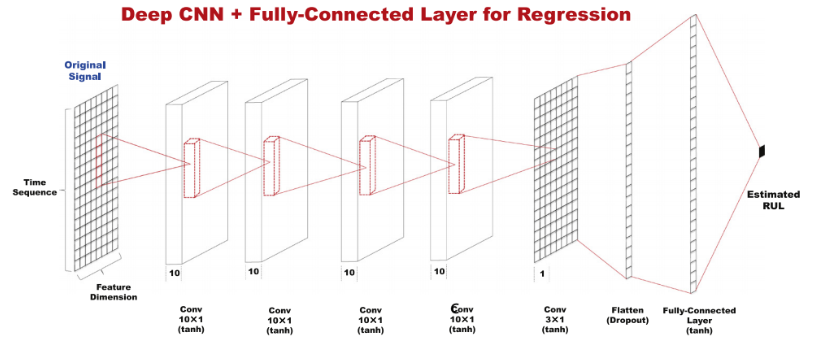

In [10]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')


Arquitectura propuesta a continuación:

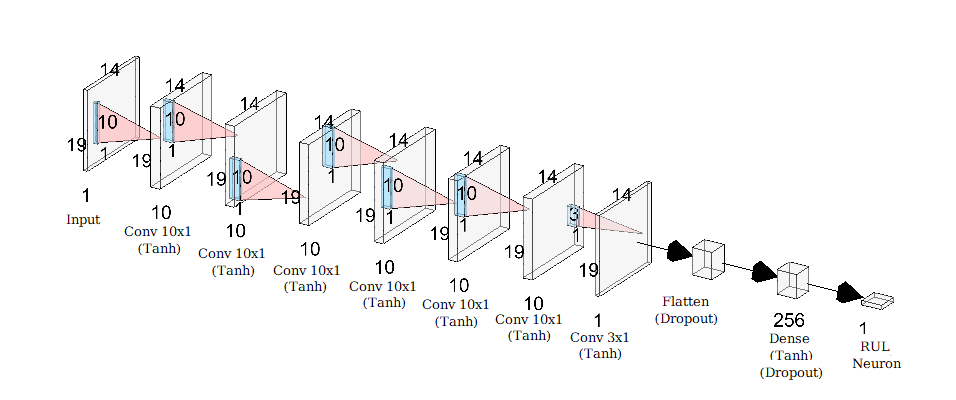

## FD001 + FD003

In [11]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2

    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3

    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4

    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5

    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    #Layer 6

    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv5')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

     #Layer 7

    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv6')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(256, activation='tanh', name='fully-connected-1')(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [12]:
cnnturbofan = cnnturbofan(((f_maps_13.shape[1]),(f_maps_13.shape[2]),(f_maps_13.shape[3])))

In [13]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan.compile(optimizer = OPTIM, loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [14]:
history = cnnturbofan.fit(x = f_maps_13, y = y_13 ,batch_size=BATCH_SIZE_T, epochs = EPOCHS_MAX ,validation_split=0.1)

Epoch 1/250
39/39 [==============================] - 2s 39ms/step - loss: 6794.3262 - root_mean_squared_error: 81.7237 - val_loss: 5035.9966 - val_root_mean_squared_error: 71.1107
Epoch 2/250
39/39 [==============================] - 1s 28ms/step - loss: 4383.9761 - root_mean_squared_error: 66.0505 - val_loss: 3869.9541 - val_root_mean_squared_error: 62.3415
Epoch 3/250
39/39 [==============================] - 1s 28ms/step - loss: 3420.6912 - root_mean_squared_error: 58.3776 - val_loss: 3079.1836 - val_root_mean_squared_error: 55.6089
Epoch 4/250
39/39 [==============================] - 1s 28ms/step - loss: 2762.8711 - root_mean_squared_error: 52.5089 - val_loss: 2537.3145 - val_root_mean_squared_error: 50.4753
Epoch 5/250
39/39 [==============================] - 1s 28ms/step - loss: 2319.4338 - root_mean_squared_error: 48.1417 - val_loss: 2171.3821 - val_root_mean_squared_error: 46.6855
Epoch 6/250
39/39 [==============================] - 1s 29ms/step - loss: 2026.5787 - root_mean_squa

In [15]:
cnnturbofan.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 14, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 10, 14, 10)        110       
_________________________________________________________________
activation (Activation)      (None, 10, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 14, 10)        1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 14, 10)        1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 14, 10)        

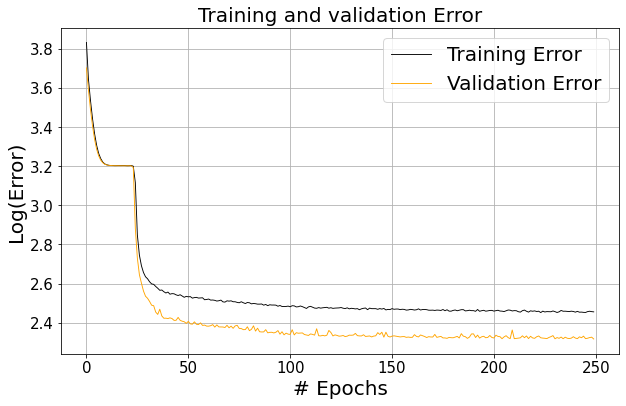

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, np.log10(loss), 'black',lw=0.9, label='Training Error')
plt.plot(epochs, np.log10(val_loss), 'orange',lw=0.9, label='Validation Error')
plt.ylabel("Log(Error)",fontsize=20)
plt.xlabel("# Epochs",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training and validation Error', fontsize=20)
plt.legend(prop={"size":20})
  

plt.show()

In [17]:
# predictions es el vector de RUL estimado de los motores del test ordenados en orden descendente a partir de su rul verdadero (dataset FD001+FD003)
predictions = cnnturbofan.predict(f_maps_test_f1f3)

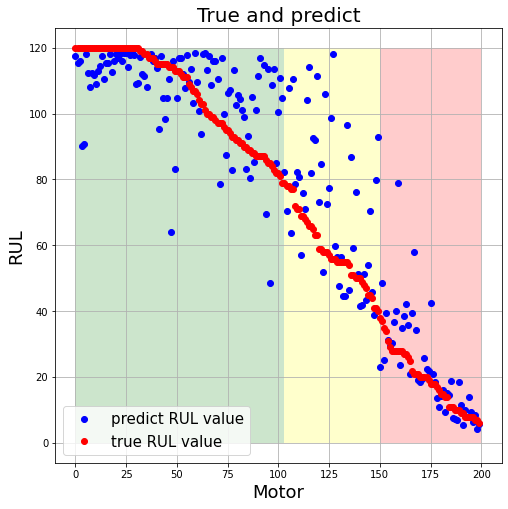

In [18]:
leng = range(len(predictions))


plt.figure(figsize=(8,8))
plt.grid(True) 
# predictions es el vector de RUL estimado de los motores del test set ordenados en orden descendente a partir de su rul verdadero (dataset FD001+FD003)
plt.plot(leng, predictions[::-1], 'bo',lw=0.9, label='predict RUL value')
# r_test_f1f3 es el vector de RUL verdadero ordenado en orden descendente del dataset FD001+FD003
plt.plot(leng, r_test_f1f3[::-1], 'ro',lw=0.9, label='true RUL value')
plt.fill_between([103,0],[120,120],facecolor='green',alpha=0.2)
plt.fill_between([150,103],[120,120],facecolor='yellow',alpha=0.2)
plt.fill_between([200,150],[120,120],facecolor='red',alpha=0.2)
plt.ylabel('RUL',fontsize=18)
plt.xlabel('Motor',fontsize=18)
plt.title('True and predict',fontsize=20)
plt.legend(prop={"size":15})
  

plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculo de RUL y RUL por tramo early / mid y late

r_test_f1f3_early = r_test_f1f3[r_test_f1f3 <= 40]
predictions_early = predictions[:(len(r_test_f1f3_early))]
# _____________________________________

r_test_f1f3_late = r_test_f1f3[r_test_f1f3 > 80]
predictions_late = predictions[(len(predictions) - len(r_test_f1f3_late)):]
# _____________________________________

r_test_f1f3_mid = r_test_f1f3[(r_test_f1f3 > 40) & (r_test_f1f3 <= 80)]
predictions_mid = predictions[(len(r_test_f1f3_early)):(len(predictions) - len(r_test_f1f3_late))]

# ____________________________________

rmse = sqrt(mean_squared_error(predictions, r_test_f1f3))
rmse_early = sqrt(mean_squared_error(predictions_early,r_test_f1f3_early))
rmse_mid = sqrt(mean_squared_error(predictions_mid,r_test_f1f3_mid))
rmse_late = sqrt(mean_squared_error(predictions_late,r_test_f1f3_late))


print(rmse)
print(rmse_early)
print(rmse_mid)
print(rmse_late)


16.851114690059124
13.625273103980174
24.11078437583329
14.003310338043393


### FD002 + FD004

In [20]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
   
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
  
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
  
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    #Layer 6

    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv5')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

     #Layer 7

    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv6')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(256, activation='tanh', name='fully-connected-1')(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [21]:
cnnturbofan2 = cnnturbofan(((f_maps_24.shape[1]),(f_maps_24.shape[2]),(f_maps_24.shape[3])))

In [22]:
cnnturbofan2.compile(optimizer = OPTIM, loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [23]:
history2 = cnnturbofan2.fit(x = f_maps_24, y = y_24 ,batch_size=BATCH_SIZE_T, epochs = EPOCHS_MAX ,validation_split=0.1)

Epoch 1/250
98/98 [==============================] - 3s 31ms/step - loss: 5220.0269 - root_mean_squared_error: 71.2897 - val_loss: 3361.0913 - val_root_mean_squared_error: 57.9803
Epoch 2/250
98/98 [==============================] - 3s 29ms/step - loss: 2647.2751 - root_mean_squared_error: 51.3003 - val_loss: 2106.9878 - val_root_mean_squared_error: 45.9086
Epoch 3/250
98/98 [==============================] - 3s 29ms/step - loss: 1884.3788 - root_mean_squared_error: 43.3402 - val_loss: 1688.6777 - val_root_mean_squared_error: 41.0978
Epoch 4/250
98/98 [==============================] - 3s 29ms/step - loss: 1658.8900 - root_mean_squared_error: 40.7097 - val_loss: 1580.8313 - val_root_mean_squared_error: 39.7571
Epoch 5/250
98/98 [==============================] - 3s 29ms/step - loss: 1606.9519 - root_mean_squared_error: 40.1112 - val_loss: 1559.0792 - val_root_mean_squared_error: 39.4776
Epoch 6/250
98/98 [==============================] - 3s 29ms/step - loss: 1601.1815 - root_mean_squa

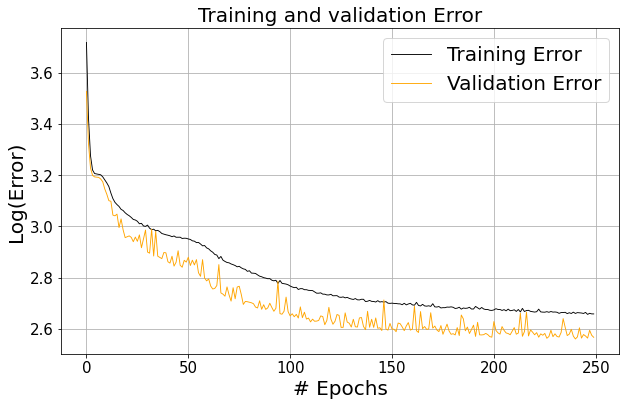

In [24]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(loss2))

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, np.log10(loss2),'black',lw=0.9, label='Training Error')
plt.plot(epochs, np.log10(val_loss2), 'orange',lw=0.9, label='Validation Error')
plt.ylabel("Log(Error)",fontsize=20)
plt.xlabel("# Epochs",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training and validation Error', fontsize=20)
plt.legend(prop={"size":20})
  

plt.show()

In [25]:
# predictions2 es el vector de RUL estimado de los motores del test ordenados en orden descendente a partir de su rul verdadero (dataset FD002+FD004)
predictions2 = cnnturbofan2.predict(f_maps_test_f2f4)

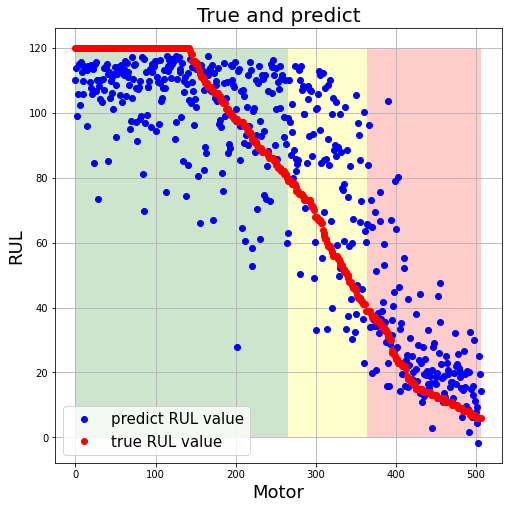

In [38]:
leng = range(len(predictions2))

plt.figure(figsize=(8,8))
plt.grid(True) 
# predictions2 es el vector de RUL estimado de los motores del test ordenados en orden descendente a partir de su rul verdadero (dataset FD002+FD004)
plt.plot(leng, predictions2[::-1], 'bo',lw=0.9, label='predict RUL value')
# r_test_f2f4 es el vector de RUL verdadero ordenado en orden descendente del dataset FD002+FD004
plt.plot(leng, r_test_f2f4[::-1], 'ro',lw=0.9, label='true RUL value')
plt.fill_between([265,0],[120,120],facecolor='green',alpha=0.2)
plt.fill_between([364,265],[120,120],facecolor='yellow',alpha=0.2)
plt.fill_between([507,364],[120,120],facecolor='red',alpha=0.2)
plt.ylabel('RUL',fontsize=18)
plt.xlabel('Motor',fontsize=18)
plt.title('True and predict',fontsize=20)
plt.legend(prop={"size":15})
  

plt.show()

In [28]:
r_test_f2f4_early = r_test_f2f4[r_test_f2f4 <= 40]
predictions_early_2 = predictions2[:(len(r_test_f2f4_early))]
# _____________________________________

r_test_f2f4_late = r_test_f2f4[r_test_f2f4 > 80]
predictions_late_2 = predictions2[(len(predictions2) - len(r_test_f2f4_late)):]
# _____________________________________

r_test_f2f4_mid = r_test_f2f4[(r_test_f2f4 > 40) & (r_test_f2f4 <= 80)]
predictions_mid_2 = predictions2[(len(r_test_f2f4_early)):(len(predictions2) - len(r_test_f2f4_late))]

# ____________________________________

rmse_2 = sqrt(mean_squared_error(predictions2, r_test_f2f4))
rmse_early_2 = sqrt(mean_squared_error(predictions_early_2,r_test_f2f4_early))
rmse_mid_2 = sqrt(mean_squared_error(predictions_mid_2,r_test_f2f4_mid))
rmse_late_2 = sqrt(mean_squared_error(predictions_late_2,r_test_f2f4_late))


print(rmse_2)
print(rmse_early_2)
print(rmse_mid_2)
print(rmse_late_2)

20.150818506756767
17.891838662961586
29.313626426164696
16.82165526367065


In [29]:
arch_fd001 = open("FD001+FD003_MSE_turbofan[12].txt","a")
arch_fd001.write(str(round(rmse,3))+ " " + str(round(rmse_early,3))+ " " + str(round(rmse_mid,3))+ " " + str(round(rmse_late,3))+ " " + str(BATCH_SIZE_T) + " " + str(EPOCHS_MAX) + " " + OPTIM + " " + str(W_H_FD001) + '\n')
arch_fd001.close()
arch_fd002 = open("FD002+FD004_MSE_turbofan[12].txt","a")
arch_fd002.write(str(round(rmse_2,3))+ " " +str(round(rmse_early_2,3))+ " " +str(round(rmse_mid_2,3))+ " " +str(round(rmse_late_2,3)) + " " + str(BATCH_SIZE_T) + " " + str(EPOCHS_MAX) + " " + OPTIM +  " " + str(W_H_FD001) + '\n')
arch_fd002.close()

Traspaso de arrays a formato JSON para construir con posterioridad sus gráficos junto con otros modelos.

In [31]:
#list to json
import codecs, json 

b = predictions.tolist() # nested lists with same data, indices
file_path = "predictions_Li_FD001+FD003_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [32]:
 # nested lists with same data, indices
file_path = "losstrain_Li_FD001+FD003_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(loss, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [33]:
 # nested lists with same data, indices
file_path = "lossval_Li_FD001+FD003_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(val_loss, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [34]:
b = predictions2.tolist() # nested lists with same data, indices
file_path = "predictions_Li_FD002+FD004_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [35]:
file_path = "losstrain_Li_FD002+FD004_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(loss2, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [36]:
file_path = "lossval_Li_FD002+FD004_"+ str(BATCH_SIZE_T) + "_" + str(EPOCHS_MAX) + "_" + str(W_H_FD001) + ".json" ## your path variable
json.dump(val_loss2, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [37]:
#json to list

obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
b_new = json.loads(obj_text)
a_new = np.array(b_new)